In the past two notebooks, we have simulated parametric data, and calculated emperical power for these simulations. Here, we'll compare the performance of the distribution-based power, empercial power and power calculated using the curve fitting parameter.

In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

import machivellian.traditional as trad
import machivellian.effects as eff
import machivellian.plot as plot
import machivellian.summarize as summarize

% matplotlib inline
sn.set_style('ticks')

In [2]:
# warnings.filterwarnings('ignore')

# Parameters

We've performed 100 simulations, which are stored in the simulation directory.

In [3]:
num_rounds = 100

sim_location = './simulations'
if not os.path.exists(sim_location):
    raise ValueError('The power simulations do not exist.'
                     'Please go back to notebooks 2 and 3 and'
                     'calculate power.'
                     )
return_dir = os.path.join(sim_location, 'extrapolation')
if not os.path.exists(return_dir):
    os.makedirs(return_dir)

We'll fit our power curves using a power value of 0.05, and calculate the fitted curves using the same value. This was the critical value used to calculate distribution-based and emperical power.

In [4]:
alpha = 0.05

Power in previous notebooks was calculated with between 5 and 95 observations, with 10 observation steps.

In [5]:
counts = np.arange(5, 100, 10)

We'll use the spectral colormap, scaled by the count depth.

In [6]:
colormap = 'Spectral'

colors = {count: list(sn.color_palette(colormap, n_colors=len(counts))[i])
          for (i, count) in enumerate(counts)}
# check_color = {count: list(colors[i]) for i, count in enumerate(counts)}

We'll look at effect sizes calculated based on the f, t, and z distributions.

In [7]:
effect_types = ['f', 'f2', 't', 'z']

# Effect size Calculations

We'll compare the behavior of distribution-based power, emperical power and the power calculated from curve fitting on the parametric tests. We can compare the behavior of emperical power, and power fit to emperical values for all tests.

In [8]:
parametric_tests = ['ttest_1', 'ttest_ind', 'anova_3', 'anova_8', 'correlation']
all_tests = ['ttest_1', 'ttest_ind', 'anova_3', 'anova_8', 'permanova', 'correlation', 'mantel']

Finally, we'll create a set of parameters for each of the distributions being evaluated. This includes the clean name, which provides a prettier title in plots, the number of groups in the tested (2 for everything except the ANOVAs), and the location of both the input emperical power calculations and output summary tables.

In [9]:
distributions = {'ttest_1': {'clean_name': 'One Sample\nT Test',
                               'num_groups': 2,
                               'input_dir': './simulations/power/ttest_1/',
                               'return_fp': './simulations/extrapolation/ttest_1.txt'
                               },
                 'ttest_ind': {'clean_name': 'Independent Sample\n T Test',
                               'num_groups': 2,
                               'input_dir': './simulations/power/ttest_ind',
                               'return_fp': './simulations/extrapolation/ttest_ind.txt'
                               },
                 'anova_3': {'clean_name': 'One way ANOVA\n(3 groups)',
                             'num_groups': 3,
                             'input_dir': './simulations/power/anova_3',
                             'return_fp': './simulations/extrapolation/anova_3.txt'
                             },
                 'anova_8': {'clean_name': 'One way ANOVA\n(8 groups)',
                             'num_groups': 8,
                             'input_dir': './simulations/power/anova_8',
                             'return_fp': './simulations/extrapolation/anova_8.txt'
                             },
                 'correlation': {'clean_name': 'Correlation',
                                 'num_groups': 2,
                                 'input_dir': './simulations/power/correlation',
                                 'return_fp': './simulations/extrapolation/correlation.txt'
                                 },
                 'permanova': {'clean_name': 'PERMANOVA',
                               'num_groups': 2,
                               'input_dir': './simulations/power/permanova2/',
                               'return_fp': './simulations/extrapolation/permanova.txt'
                               },
                 'mantel': {'clean_name': 'Mantel',
                            'num_groups': 2,
                            'input_dir': './simulations/power/mantel2/',
                            'return_fp': './simulations/extrapolation/mantel.txt'
                            },
                 }

We'll start by calculating the emperical and extrapolated effect sizes for the parametric tests.

In [10]:
for test_name in all_tests:
#     print(test_name)
    power_dir = distributions[test_name]['input_dir']
    num_groups = distributions[test_name]['num_groups']
    return_fp = distributions[test_name]['return_fp']
    
    if not os.path.exists(power_dir):
        raise ValueError('%s does not exist' % power_dir)
        
    summaries = []
    
    # Loops through the rounds
    for i in range(num_rounds):
        # Loads through the power simulation for the round
        power_fp = os.path.join(power_dir, 'simulation_%i.p' % i)
        
        with open(power_fp, 'rb') as f_:
            sim = pickle.load(f_)
        if 'alpha' not in sim:
            sim['alpha'] = 0.05
        sim2 = {''}
        
        # Pulls the previously calculated power values
        run_summary = summarize.summarize_power(power_summary=sim,
                                                sim_num=i,
                                                test=test_name,
                                                colors=colors,
                                                dists=effect_types,
                                                num_groups=num_groups,
                                               )
        summaries.append(pd.DataFrame(run_summary))
    summaries = pd.concat(summaries)
    summaries.to_csv(return_fp, sep='\t')
    distributions[test_name]['summary'] = summaries


# Comparison of Power Calculations

We will start with the comparison of distribution based power calculations to the emperical power calculations, and power fit using curves.

## Distribution Power and Emperical Power

We're going to plot a comparison between the emperical and traditional power calculations, to see if there's a strong relationship. We'll plot the distribution-based power on the x axis and the emperical power on the y axis.

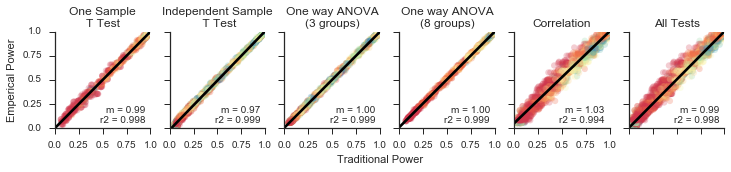

In [11]:
# Sets up the figure and axes
tr_fig, tr_axes = plt.subplots(5, 6)
tr_fig.set_size_inches(12, 10)

# Hides the axes until they're needed
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(False)

sn.despine()

summaries = []
for idx, (test_name, ax) in enumerate(zip(*(parametric_tests, tr_axes[0, :-1]))):
    summary = distributions[test_name]['summary']
    summaries.append(summary)
    plot.gradient_regression(ax, 
                             y='emperical', 
                             x='traditional', 
                             gradient='colors', 
                             data=summary, 
                             alpha=0.25)
    plot.format_regression_axis(ax)
    ax.set_title(distributions[test_name]['clean_name'])
    ax.set_xticklabels(ax.get_xticks())
ax = tr_axes[0, -1]
summaries = pd.concat(summaries)
plot.gradient_regression(ax,
                         y='emperical', 
                         x='traditional', 
                         gradient='colors', 
                         data=summaries, 
                         alpha=0.25
                         )
plot.format_regression_axis(ax)
ax.set_title('All Tests')

tr_axes[0][0].set_yticklabels(ax.get_yticks())
tr_axes[0][0].set_ylabel('Emperical Power')
l = tr_axes[0][2].set_xlabel('Traditional Power')
l.set_position((1, 1))

## Distribution-based power and Fit Power

Let's also compare the performance of power calculated using the fit effect size to the power calculated from the effect size fit to the emperical power.

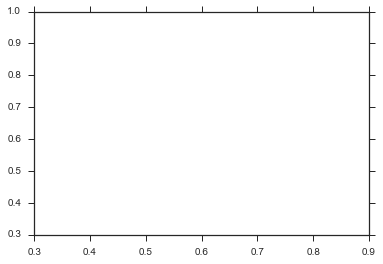

In [12]:
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(True)
for ax in tr_axes[0]:
    ax.set_xticklabels('')
    ax.set_xlabel('')
    
for idc, test_name in enumerate(parametric_tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg in zip(*[effect_types, tr_axes.T[idc][1:]]):
        plot.gradient_regression(ax=ax_reg, 
                            x='traditional', 
                            y='%s_power' % metric, 
                            gradient='colors', 
                            alpha=0.25,
                            data=summary
                            )
        plot.format_regression_axis(ax_reg)
        if metric == 'z':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if test_name == parametric_tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())

for metric, ax_c in zip(*[effect_types, tr_axes.T[-1][1:]]):
    plot.gradient_regression(ax_c,
                             x='traditional',
                             y='%s_power' % metric,
                             gradient='colors',
                             alpha=0.05,
                             data=summaries
                             )
    plot.format_regression_axis(ax_c)
    if metric == 'z':
        ax_reg.set_xticklabels(ax_c.get_xticks())
        
l = tr_axes[-1][2].set_xlabel('Distribution-based Power')
l.set_position((1, 1))
tr_axes[1][0].set_ylabel('F Power\nk DOF')
tr_axes[2][0].set_ylabel('F Power\n2 DOF')
tr_axes[3][0].set_ylabel('T Power')
tr_axes[4][0].set_ylabel('Z Power')

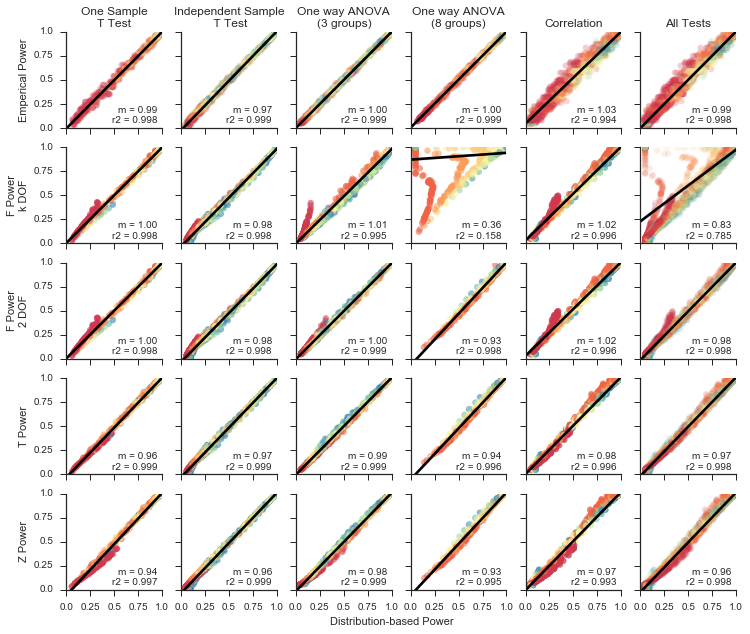

In [13]:
tr_axes[-1][-1].set_xticklabels(tr_axes[-1][-1].get_xticks())
tr_fig

In [14]:
tr_fig.savefig('/Users/jdebelius/Desktop/distribution_comparison.png')

For most of the effect sizes and fits, we find the behavior of the curve 

Let's also compare the behavior of the emperical power and the fit power curves. 

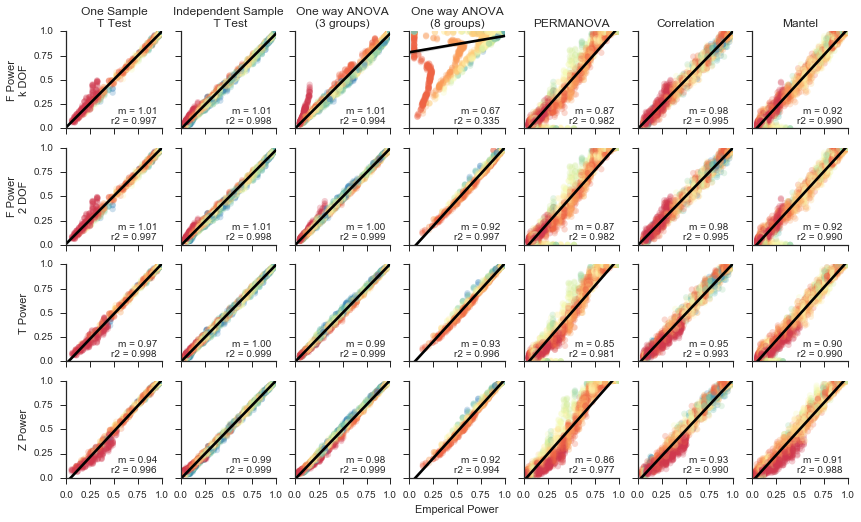

In [45]:
# Sets up the figure and axes
er_fig, er_axes = plt.subplots(4, 7)
er_fig.set_size_inches(14, 8)
sn.despine()

for idc, test_name in enumerate(all_tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg in zip(*[effect_types, er_axes.T[idc]]):
        plot.gradient_regression(ax=ax_reg, 
                            x='emperical', 
                            y='%s_power' % metric, 
                            gradient='colors', 
                            alpha=0.25,
                            data=summary
                            )
        plot.format_regression_axis(ax_reg)
        if metric == 'z':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if metric == 'f':
            ax_reg.set_title(distributions[test_name]['clean_name'])
        if test_name == all_tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())
            ax_reg.set_ylabel(metric)
        
er_axes[-1][3].set_xlabel('Emperical Power')
l.set_position((1, 1))
er_axes[0][0].set_ylabel('F Power\nk DOF')
er_axes[1][0].set_ylabel('F Power\n2 DOF')
er_axes[2][0].set_ylabel('T Power')
er_axes[3][0].set_ylabel('Z Power')

Based on the color by depth, it looks like the emperical power and extrapolated values do not behave as well at lower count values. We can recalculate the fit curves excluding these lower values, to see if this improves the fit. We'll exclude points with less tahn 5 observations and emperical values between less than 0.05 or greater than 0.95, as the percentage point functions tend towards aspmototic values at thoses extremes.

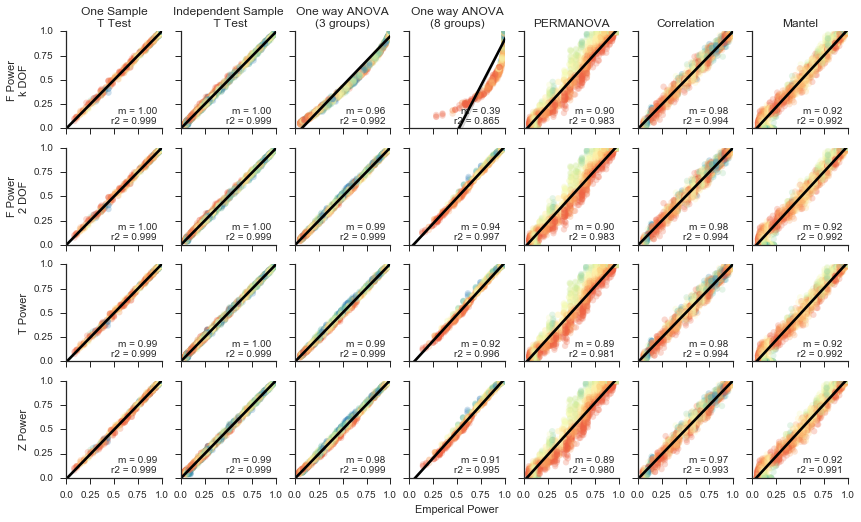

In [46]:
# Sets up the figure and axes
em_fig, em_axes = plt.subplots(4, 7)
em_fig.set_size_inches(14, 8)

sn.despine()

for idx, (test_name, ax) in enumerate(zip(*(all_tests, em_axes[0]))):
    summary = distributions[test_name]['summary']
    drop_index = summary.index[((summary['counts'] == 5) | 
                                (summary['emperical'] < 0.05) | 
                                (summary['emperical'] > 0.95))]
    mod = summarize.modify_effect_size(summary, drop_index, effect_types)
    mod.loc[mod['counts'] == 5, 'emperical'] = np.nan
    for metric, ax_reg in zip(*[effect_types, em_axes.T[idx]]):
        plot.gradient_regression(ax=ax_reg, 
                                 x='emperical', 
                                 y='%s_power' % metric, 
                                 gradient='colors', 
                                 alpha=0.25,
                                 data=mod
                                 )
        plot.format_regression_axis(ax_reg)
        if metric == 'z':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if metric == 'f':
            ax_reg.set_title(distributions[test_name]['clean_name'])
        if test_name == all_tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())
            ax_reg.set_ylabel(
                '%s Power' % metric.replace('_', ' ').capitalize()
                )
l = tr_axes[-1][2].set_xlabel('Distribution-based Power')
l.set_position((1, 1))
em_axes[0][0].set_ylabel('F Power\nk DOF')
em_axes[1][0].set_ylabel('F Power\n2 DOF')
em_axes[2][0].set_ylabel('T Power')
em_axes[3][0].set_ylabel('Z Power')
em_axes[-1][3].set_xlabel('Emperical Power')

The exclusion of the first set of emperical points appears to slightly improve the fit of the dataset. However, for smaller datasets, it may be worth the uncertainty assoicated with the extreme values, as long as th majority of values are not extreme.

We also notice that the F distribution with $k - 1$ degrees of freedom does not behave well for the 8 group ANOVA. With fewer groups, the F distribution behaves simillarly to the T and Z distribution. However, as the number of groups increase, the distribution does not behave appropriately. This suggests that the power calculation may be better approximated by assuming a normal distribution than using the approximation based on group size.

Finally, an additional consideration in selecting the appropriate effect size metric is to determine how frequently a particular metric cannot be defined.

In [44]:
summaries.groupby('test').count()[['f_effect', 'f2_effect', 't_effect', 'z_effect']
                                  ].div(summaries.groupby('test').count()['alpha'], axis=0)

,f_effect,f2_effect,t_effect,z_effect
test,,,,
anova_3,0.839298,0.870526,0.875088,0.882807
anova_8,0.516260,0.646793,0.652213,0.652213
correlation,0.462439,0.462439,0.499268,0.512195
ttest_1,0.606566,0.606566,0.634343,0.634343
ttest_ind,0.919728,0.919728,0.919048,0.983673


So, in this notebook we have demonstrated that emperically calculated power behaves as well as distribution-based calculations for parametric distributions. We've furthermore observed that fitting the emperical curves with effect size parameters generates power curves which closely fit both the distribution and emperical data. However, we find the performance o the different fitting approaches varies. 

The calculation based on the z distribution is the most robust, while the calculation based on the F distribution is the least robust, where robustness is measured as the percentgae of calculations where power could not be calculated.

In the next notebook, we will explore the behavior of the permutative tests under similar condtions, to validate that these tests also work.